In [1]:
import pandas as pd
import numpy as np
import pickle
# data
dat = pickle.load(open('../data/zooni/annotations_1105.pkl', 'rb'))

import torch
torch.has_mps

True

In [2]:
# create connection df
connection = dat[['connection', 'text']]

subj = dat[['subject', 'text']]

# encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
subj['subject'] = le.fit_transform(subj['subject'])

/var/folders/jj/bt0ykz9n5_16z2gvbybl0tbc0000gn/T/ipykernel_58058/3564290673.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj['subject'] = le.fit_transform(subj['subject'])


In [ ]:
torch.cuda.empty_cache()

---

## TYPE OF CONNECTION

In [3]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup

# make training and evaluation sets
from sklearn.model_selection import train_test_split
train, eval = train_test_split(connection, test_size=0.2, random_state=42, stratify=connection['connection'])

# Extract text and labels from your DataFrame
x = list(train['text'].values)
# convert string labels to numeric values, 1 for inquisition and 2 for disclosure
labels = [1 if label == 'Inquisition' else 0 for label in train['connection'].values]


## Initialize the tokenizer and model
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.config.pad_token_id = model.config.eos_token_id

# Encode the text data and convert labels to tensors
inputs = tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=128).to('mps')
labels = torch.tensor(labels).to('mps')

# create dataset
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

# create dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# create training args
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=10,
    save_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
device = torch.device('mps')
model.to(device)
inputs.to(device)
labels.to(device)
device

device(type='mps')

In [5]:
from transformers import Trainer
# Initialize Trainer
from datasets import Dataset

# Assuming you have a list of text and labels
data = {
    'text': x,
    'labels': labels
}
evaluation_data = {
    'text': list(eval['text'].values),
    'labels': [1 if label == 'Inquisition' else 0 for label in eval['connection'].values]
}

# # Create a dataset
# training_dataset = Dataset.from_dict(data)

# # Initialize the Trainer with the dataset
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     data_collator=DataCollatorWithPadding(tokenizer),
#     train_dataset=training_dataset,
# )

# # Start training
# trainer.train()


# Create a Hugging Face dataset
dataset = Dataset.from_dict(data)
eval_dataset = Dataset.from_dict(evaluation_data)
# Define a function to preprocess the data
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Preprocess the dataset
encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_eval_dataset = eval_dataset.map(preprocess_function, batched=True)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    train_dataset=encoded_dataset,
    eval_dataset=encoded_eval_dataset
)

trainer.train()
eval_results = trainer.evaluate(encoded_eval_dataset)
# Save the model
trainer.save_model()

# Save the tokenizer
# tokenizer.save_pretrained('./results')
print(eval_results)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lab218 (social-nlp). Use `wandb login --relogin` to force relogin


 12%|█▎        | 10/80 [00:14<00:54,  1.29it/s]

{'loss': 2.0005, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.62}



 12%|█▎        | 10/80 [00:18<00:54,  1.29it/s]

{'eval_loss': 2.1460366249084473, 'eval_runtime': 3.8745, 'eval_samples_per_second': 16.776, 'eval_steps_per_second': 1.29, 'epoch': 0.62}


 25%|██▌       | 20/80 [00:28<00:45,  1.31it/s]

{'loss': 2.1491, 'learning_rate': 2.0000000000000003e-06, 'epoch': 1.25}



 25%|██▌       | 20/80 [00:29<00:45,  1.31it/s]

{'eval_loss': 2.06001877784729, 'eval_runtime': 0.8273, 'eval_samples_per_second': 78.573, 'eval_steps_per_second': 6.044, 'epoch': 1.25}


 38%|███▊      | 30/80 [00:38<00:37,  1.35it/s]

{'loss': 1.6043, 'learning_rate': 3e-06, 'epoch': 1.88}


                                               
 38%|███▊      | 30/80 [00:39<00:37,  1.35it/s]

{'eval_loss': 1.9366815090179443, 'eval_runtime': 0.8511, 'eval_samples_per_second': 76.374, 'eval_steps_per_second': 5.875, 'epoch': 1.88}


 50%|█████     | 40/80 [00:49<00:29,  1.37it/s]

{'loss': 1.4544, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.5}


                                               
 50%|█████     | 40/80 [00:49<00:29,  1.37it/s]

{'eval_loss': 1.7842634916305542, 'eval_runtime': 0.8554, 'eval_samples_per_second': 75.988, 'eval_steps_per_second': 5.845, 'epoch': 2.5}


 62%|██████▎   | 50/80 [00:59<00:21,  1.38it/s]

{'loss': 1.2072, 'learning_rate': 5e-06, 'epoch': 3.12}


                                               
 62%|██████▎   | 50/80 [01:00<00:21,  1.38it/s]

{'eval_loss': 1.585748314857483, 'eval_runtime': 0.8561, 'eval_samples_per_second': 75.928, 'eval_steps_per_second': 5.841, 'epoch': 3.12}


 75%|███████▌  | 60/80 [01:09<00:14,  1.37it/s]

{'loss': 1.1047, 'learning_rate': 6e-06, 'epoch': 3.75}


                                               
 75%|███████▌  | 60/80 [01:10<00:14,  1.37it/s]

{'eval_loss': 1.2772217988967896, 'eval_runtime': 0.8543, 'eval_samples_per_second': 76.086, 'eval_steps_per_second': 5.853, 'epoch': 3.75}


 88%|████████▊ | 70/80 [01:20<00:07,  1.37it/s]

{'loss': 0.8822, 'learning_rate': 7.000000000000001e-06, 'epoch': 4.38}


                                               
 88%|████████▊ | 70/80 [01:20<00:07,  1.37it/s]

{'eval_loss': 0.9954636693000793, 'eval_runtime': 0.84, 'eval_samples_per_second': 77.377, 'eval_steps_per_second': 5.952, 'epoch': 4.38}


100%|██████████| 80/80 [01:30<00:00,  1.36it/s]

{'loss': 0.7727, 'learning_rate': 8.000000000000001e-06, 'epoch': 5.0}


                                               
100%|██████████| 80/80 [01:31<00:00,  1.36it/s]

{'eval_loss': 0.8513472080230713, 'eval_runtime': 0.8669, 'eval_samples_per_second': 74.983, 'eval_steps_per_second': 5.768, 'epoch': 5.0}


100%|██████████| 80/80 [01:34<00:00,  1.18s/it]


{'train_runtime': 105.0896, 'train_samples_per_second': 12.18, 'train_steps_per_second': 0.761, 'train_loss': 1.3968984365463257, 'epoch': 5.0}


100%|██████████| 5/5 [00:01<00:00,  4.40it/s]


{'eval_loss': 0.8513472080230713, 'eval_runtime': 1.9465, 'eval_samples_per_second': 33.393, 'eval_steps_per_second': 2.569, 'epoch': 5.0}


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming that 'true_labels' are the ground truth labels and 'predicted_labels' are the model's predicted labels
true_labels = [1 if label == 'Inquisition' else 0 for label in eval['connection'].values]
predicted_labels = trainer.predict(encoded_eval_dataset).predictions.argmax(-1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print the evaluation metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))


100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

Accuracy: 0.46
Precision: 0.49
Recall: 0.85
F1-Score: 0.62


---

## SUBJECT

In [7]:
# repeat for subject
# make training and evaluation sets
torch.cuda.empty_cache()

train, eval = train_test_split(subj, test_size=0.2, random_state=42, stratify=subj['subject'])

# Extract text and labels from your DataFrame
x = list(train['text'].values)
labels = train['subject'].values

In [8]:
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))
model.config.pad_token_id = model.config.eos_token_id

# Encode the text data and convert labels to tensors
inputs = tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=128).to('mps')
labels = torch.tensor(labels).to('mps')

# create dataset
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

# create dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
device = torch.device('mps')
model.to(device)
inputs.to(device)
labels.to(device)
device

device(type='mps')

In [10]:
# train
data = {
    'text': x,
    'labels': labels
}
evaluation_data = {
    'text': list(eval['text'].values),
    'labels': eval['subject'].values
}

# Create a Hugging Face dataset
dataset = Dataset.from_dict(data)
eval_dataset = Dataset.from_dict(evaluation_data)
# Define a function to preprocess the data
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Preprocess the dataset
encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_eval_dataset = eval_dataset.map(preprocess_function, batched=True)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    train_dataset=encoded_dataset,
    eval_dataset=encoded_eval_dataset
)

trainer.train()
eval_results = trainer.evaluate(encoded_eval_dataset)
# Save the model
trainer.save_model("subject_model")

print(eval_results)

 12%|█▎        | 10/80 [00:10<00:51,  1.36it/s]               

{'loss': 6.3131, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.62}


                                               
 12%|█▎        | 10/80 [00:11<00:51,  1.36it/s]

{'eval_loss': 6.626993656158447, 'eval_runtime': 1.1786, 'eval_samples_per_second': 55.15, 'eval_steps_per_second': 4.242, 'epoch': 0.62}


 25%|██▌       | 20/80 [00:21<00:48,  1.23it/s]

{'loss': 6.27, 'learning_rate': 2.0000000000000003e-06, 'epoch': 1.25}


                                               
 25%|██▌       | 20/80 [00:22<00:48,  1.23it/s]

{'eval_loss': 6.429929256439209, 'eval_runtime': 0.9258, 'eval_samples_per_second': 70.211, 'eval_steps_per_second': 5.401, 'epoch': 1.25}


 38%|███▊      | 30/80 [00:32<00:39,  1.27it/s]

{'loss': 5.6979, 'learning_rate': 3e-06, 'epoch': 1.88}


                                               
 38%|███▊      | 30/80 [00:33<00:39,  1.27it/s]

{'eval_loss': 6.067989349365234, 'eval_runtime': 0.8466, 'eval_samples_per_second': 76.774, 'eval_steps_per_second': 5.906, 'epoch': 1.88}


 50%|█████     | 40/80 [00:43<00:29,  1.34it/s]

{'loss': 5.4894, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.5}


                                               
 50%|█████     | 40/80 [00:44<00:29,  1.34it/s]

{'eval_loss': 5.541857719421387, 'eval_runtime': 0.8548, 'eval_samples_per_second': 76.04, 'eval_steps_per_second': 5.849, 'epoch': 2.5}


 62%|██████▎   | 50/80 [00:54<00:22,  1.35it/s]

{'loss': 3.9561, 'learning_rate': 5e-06, 'epoch': 3.12}


                                               
 62%|██████▎   | 50/80 [00:54<00:22,  1.35it/s]

{'eval_loss': 4.639289379119873, 'eval_runtime': 0.8523, 'eval_samples_per_second': 76.263, 'eval_steps_per_second': 5.866, 'epoch': 3.12}


 75%|███████▌  | 60/80 [01:04<00:14,  1.36it/s]

{'loss': 3.1089, 'learning_rate': 6e-06, 'epoch': 3.75}


                                               
 75%|███████▌  | 60/80 [01:05<00:14,  1.36it/s]

{'eval_loss': 2.8815629482269287, 'eval_runtime': 0.8558, 'eval_samples_per_second': 75.949, 'eval_steps_per_second': 5.842, 'epoch': 3.75}


 88%|████████▊ | 70/80 [01:15<00:07,  1.36it/s]

{'loss': 1.9668, 'learning_rate': 7.000000000000001e-06, 'epoch': 4.38}


                                               
 88%|████████▊ | 70/80 [01:15<00:07,  1.36it/s]

{'eval_loss': 2.0633935928344727, 'eval_runtime': 0.8284, 'eval_samples_per_second': 78.464, 'eval_steps_per_second': 6.036, 'epoch': 4.38}


100%|██████████| 80/80 [01:25<00:00,  1.38it/s]

{'loss': 1.6237, 'learning_rate': 8.000000000000001e-06, 'epoch': 5.0}


                                               
100%|██████████| 80/80 [01:26<00:00,  1.38it/s]

{'eval_loss': 1.6272696256637573, 'eval_runtime': 0.8734, 'eval_samples_per_second': 74.418, 'eval_steps_per_second': 5.724, 'epoch': 5.0}


100%|██████████| 80/80 [01:29<00:00,  1.12s/it]


{'train_runtime': 89.4733, 'train_samples_per_second': 14.306, 'train_steps_per_second': 0.894, 'train_loss': 4.303243088722229, 'epoch': 5.0}


100%|██████████| 5/5 [00:00<00:00,  7.56it/s]


{'eval_loss': 1.6272696256637573, 'eval_runtime': 0.8841, 'eval_samples_per_second': 73.517, 'eval_steps_per_second': 5.655, 'epoch': 5.0}


In [11]:
# get metrics
true_labels = eval['subject'].values
predicted_labels = trainer.predict(encoded_eval_dataset).predictions.argmax(-1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Print the evaluation metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

100%|██████████| 5/5 [00:00<00:00,  5.26it/s]

Accuracy: 0.38
Precision: 0.38
Recall: 0.38
F1-Score: 0.34


---

## OBJECTIVE

In [17]:
# transform data
objectives = ['Quality', 'Legality', 'Effects', 'Methods', 'Combination of Substances', 'Mental Health',
          'N/A', 'Other', 'Overdose', 'Nurturant Support & Morality', 'Withdrawal', 'Safety', 'Relapse']

# create a column for each topic
obj = pd.DataFrame(columns=objectives)

for t in objectives:
    obj[t] = dat['objective'].apply(lambda x: 1 if t in x else 0)

obj = obj.fillna(0)

# add the text column
obj['text'] = dat['text']

In [16]:
# repeat for objective
torch.cuda.empty_cache()


In [18]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup

# make training and evaluation sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments

# Split your data into training and evaluation sets
train_data, eval_data = train_test_split(obj, test_size=0.2, random_state=42)


In [19]:
# Initialize the GPT-2 tokenizer and model
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
train_inputs = tokenizer(list(train_data['text']), padding=True, truncation=True, return_tensors='pt')
eval_inputs = tokenizer(list(eval_data['text']), padding=True, truncation=True, return_tensors='pt')



In [20]:
# Convert the labels to tensors
train_labels = torch.tensor(train_data[objectives].values, dtype=torch.long)
eval_labels = torch.tensor(eval_data[objectives].values, dtype=torch.long)


In [21]:
# move to mps
device = "mps"
train_inputs = train_inputs.to(device)
eval_inputs = eval_inputs.to(device)
train_labels = train_labels.to(device)
eval_labels = eval_labels.to(device)

In [22]:
model = GPT2ForSequenceClassification.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    save_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_total_limit=2,
)


In [27]:
#  Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 
#  to disable the cache and use the default PyTorch allocator.
#  Use PYTORCH_MPS=1 to enable MPS.
from transformers import Trainer
from datasets import Dataset

# Create a DataCollator with padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# trainer expects a Dataset object
train_dataset = {
    'input_ids': train_inputs['input_ids'],
    'attention_mask': train_inputs['attention_mask'],
    'labels': train_labels
}

eval_dataset = {
    'input_ids': eval_inputs['input_ids'],
    'attention_mask': eval_inputs['attention_mask'],
    'labels': eval_labels
}

train_dataset = Dataset.from_dict(train_dataset)
eval_dataset = Dataset.from_dict(eval_dataset)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=lambda p: accuracy_score(p.predictions.argmax(-1), p.label_ids),
)

# Train the model
trainer.train()

# Evaluate the model
eval_metrics = trainer.evaluate()
print(eval_metrics)

RuntimeError: MPS backend out of memory (MPS allocated: 13.40 GB, other allocations: 4.30 GB, max allowed: 18.13 GB). Tried to allocate 468.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [28]:
# Preprocess the text and labels for training and evaluation
class MultiLabelDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_length=128):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.text[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': label
        }


In [29]:
# Create training and evaluation datasets
train_dataset = MultiLabelDataset(train_data['text'], train_labels, tokenizer)
eval_dataset = MultiLabelDataset(eval_data['text'], eval_labels, tokenizer)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)


In [30]:
# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()

# Save the model
trainer.save_model("objective_classifier")

AttributeError: 'MultiLabelDataset' object has no attribute '_data'

In [17]:
device = torch.device('mps')
model.to(device)
train_inputs.to(device)
eval_inputs.to(device)
train_labels.to(device)
eval_labels.to(device)
device

device(type='mps')

In [24]:
data = {
    'text': list(train_data['text'].values),
    'labels': obj
}

evaluation_data = {
    'text': list(eval_data['text'].values),
    'labels': eval_data[objectives].values
}

In [25]:
# Create a Hugging Face dataset
dataset = Dataset.from_dict(data)
eval_dataset = Dataset.from_dict(evaluation_data)


ArrowInvalid: Column 1 named labels expected length 256 but got length 14

In [75]:
# Create training and evaluation datasets
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
eval_dataset = TensorDataset(eval_inputs['input_ids'], eval_inputs['attention_mask'], eval_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_total_limit=2,
)


AssertionError: Size mismatch between tensors

In [69]:
from sklearn.preprocessing import MultiLabelBinarizer

model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=len(objectives))
model.config.pad_token_id = model.config.eos_token_id

# Encode the training data and create the training dataset
train_inputs = tokenizer(list(train['text']), padding=True, truncation=True, return_tensors="pt", max_length=128)
train_labels = mlb.transform(train.iloc[:, 1:])  # Assuming label columns start from the second column
train_labels = torch.tensor(train_labels, dtype=torch.float32)
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)

# Encode the evaluation data and create the evaluation dataset
eval_inputs = tokenizer(list(eval_data['text']), padding=True, truncation=True, return_tensors="pt", max_length=128)
eval_labels = mlb.transform(eval_data.iloc[:, 1:])  # Assuming label columns start from the second column
eval_labels = torch.tensor(eval_labels, dtype=torch.float32)
eval_dataset = TensorDataset(eval_inputs['input_ids'], eval_inputs['attention_mask'], eval_labels)

# create dataloader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:878: UserWarning: unknown class(es) [' ', '&', '/', 'A', 'C', 'E', 'H', 'L', 'M', 'N', 'O', 'R', 'S', 'W', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] will be ignored
  warnings.warn(


AssertionError: Size mismatch between tensors

In [65]:
device = torch.device('mps')
model.to(device)
inputs.to(device)
labels.to(device)
eval_inputs.to(device)
eval_labels.to(device)
device

device(type='mps')

In [66]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,  # Training batch size
    per_device_eval_batch_size=16,   # Evaluation batch size
    save_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_total_limit=2,
)


In [67]:
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(dataloader) * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# train

# Set up and run the Trainer for training
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

trainer.train()

eval_results = trainer.evaluate(eval_dataset)
# Save the model
trainer.save_model("objective_model")

print(eval_results)

/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/140 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'keys'

In [ ]:

# train
data = {
    'text': x,
    'labels': labels
}
evaluation_data = {
    'text': list(eval['text'].values),
    'labels': eval[objectives].values
}

# Create a Hugging Face dataset
dataset = Dataset.from_dict(data)
eval_dataset = Dataset.from_dict(evaluation_data)
# Define a function to preprocess the data
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Preprocess the dataset
encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_eval_dataset = eval_dataset.map(preprocess_function, batched=True)


In [56]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    train_dataset= encoded_dataset,
    eval_dataset=encoded_eval_dataset
)

trainer.train()
eval_results = trainer.evaluate(encoded_eval_dataset)
# Save the model
trainer.save_model("objective_model")

print(eval_results)

ValueError: Expected input batch_size (8) to match target batch_size (16).

In [ ]:
# get metrics
true_labels = eval[].values
predicted_labels = trainer.predict(encoded_eval_dataset).predictions.argmax(-1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Print the evaluation metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

In [ ]:


# Define the model name
model_name = "gpt2"
topics = ['Symptoms', 'Guidance', 'Withdrawal', 'Recovery', 'Relapse', 'Sobriety',
          'Overdose', 'Social Support', 'Cultural Reference', 'Values', 'Banter', 
          'Not Applicable']
## Initialize the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=len(topics))
model.config.pad_token_id = model.config.eos_token_id

# Encode the text data and convert labels to tensors
inputs = tokenizer(list(dat2['Text']), padding=True, truncation=True, return_tensors="pt", max_length=128).to('mps')
labels = torch.tensor(dat2[topics].values, dtype=torch.float32).to('mps')


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device('mps')
model.to(device)
inputs.to(device)
labels.to(device)
device

device(type='mps')

In [ ]:
# Split the data into a training dataset and an evaluation dataset
# You can choose the percentage for the evaluation dataset, for example, 10%.
eval_split = int(0.1 * len(inputs))
eval_inputs, eval_labels = inputs[:eval_split], labels[:eval_split]
train_inputs, train_labels = inputs[eval_split:], labels[eval_split:]

# Create DataLoaders for both training and evaluation datasets
train_dataloader = DataLoader(TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels), batch_size=8)
eval_dataloader = DataLoader(TensorDataset(eval_inputs['input_ids'], eval_inputs['attention_mask'], eval_labels), batch_size=8)

In [ ]:
# Create a DataLoader
# dataset = TensorDataset(inputs.input_ids, inputs.attention_mask, labels)
# dataloader = DataLoader(dataset, batch_size=8)


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-fine-tuned",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    save_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_total_limit=2,
)

In [ ]:
# Initialize Trainer
# Initialize the optimizer (AdamW)
# Initialize the learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)

num_training_steps = len(train_dataloader) * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:

# Initialize Trainer with optimizer and scheduler
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     data_collator=data_collator,
#     train_dataset=train_dataloader,
#     eval_dataset=eval_dataloader,  # Include the evaluation dataset
#     optimizers=(optimizer, scheduler),
# )


Epoch 1, Average Training Loss: 0.26106315513826767
Epoch 2, Average Training Loss: 0.25861914118505874
Epoch 3, Average Training Loss: 0.2594894623419024
Epoch 4, Average Training Loss: 0.26018973144720187
Epoch 5, Average Training Loss: 0.2602604152459019


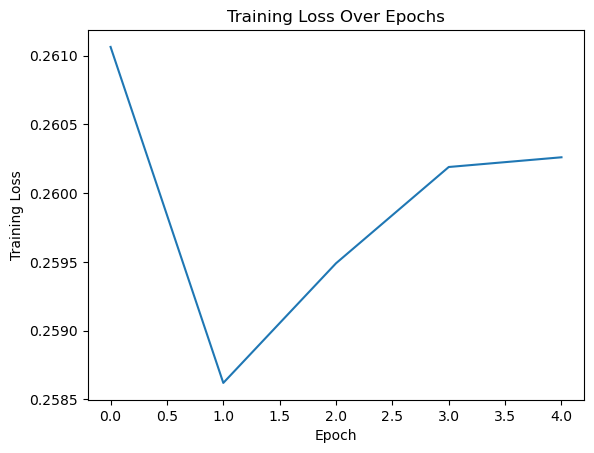

Evaluation predictions is empty, cannot perform evaluation.


In [ ]:
# Manually perform the training loop
# Lists to store training loss for visualization
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

training_losses = []

for epoch in range(training_args.num_train_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_dataloader:
        batch_mps = {
            'input_ids': batch[0].to('mps'),
            'attention_mask': batch[1].to('mps'),
            'labels': batch[2].to('mps')
        }
        # input_ids, attention_mask, labels = batch
        # input_ids = input_ids.to(device)
        # attention_mask = attention_mask.to(device)
        # labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**batch_mps)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)  # Append training loss for visualization
    print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss}")

# Plot and visualize the training loss
plt.plot(training_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")
plt.show()

# Manually predict and evaluate the model
eval_predictions = []
eval_labels = []
# Check if the evaluation dataset is not empty
if eval_inputs and 'input_ids' in eval_inputs:
    for batch in eval_dataloader:
        batch_mps = {
            'input_ids': batch['input_ids'].to('mps'),
            'attention_mask': batch['attention_mask'].to('mps'),
            'labels': batch['labels']
        }
        print('input_ids:', batch_mps['input_ids'])
        with torch.no_grad():
            output = model(input_ids=batch_mps['input_ids'], attention_mask=batch_mps['attention_mask'])
            eval_predictions.append(output.logits)
            eval_labels.append(batch_mps['labels'])
            print('logits:', output.logits)
            print('labels:', batch_mps['labels'])


    if len(eval_predictions) > 0:
        eval_predictions = torch.cat(eval_predictions, dim=0)
        eval_labels = torch.cat(eval_labels, dim=0)
        eval_loss = torch.nn.BCEWithLogitsLoss()(eval_predictions, eval_labels).mean()

        # Convert predictions and labels to NumPy arrays
        eval_predictions = eval_predictions.cpu().numpy()
        eval_labels = eval_labels.cpu().numpy()

        # Calculate accuracy, precision, recall, and F1 score
        accuracy = accuracy_score(eval_labels, (eval_predictions > 0.5).astype(int))
        precision = precision_score(eval_labels, (eval_predictions > 0.5).astype(int), average='micro')
        recall = recall_score(eval_labels, (eval_predictions > 0.5).astype(int), average='micro')
        f1 = f1_score(eval_labels, (eval_predictions > 0.5).astype(int), average='micro')

        # Print evaluation metrics
        print("***** Evaluation Metrics *****")
        print(f"Eval Loss: {eval_loss.item()}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
    else:
        print("Evaluation predictions is empty, cannot perform evaluation.")
else:
    print("Evaluation dataset is empty, cannot perform evaluation.")
    # pass # Skip the evaluation step if the evaluation dataset is empty

# Save the model
model.save_pretrained("./gpt2-fine-tuned2")


